# Dimensions of sound

The notebook is used in my Medium article - [MIR: introduction](https://medium.com/@kate.ruksha/introduction-into-music-information-retrieval-part-1-2dc874cda763) to give an overview of specifics of working with audio data, explain relationship between Math and Music and apply this knowledge to generate a song!

Once you are familiar with the basics, check out the second part of this lecture dedicated to feature engineering for audio data at [feature engineering](https://medium.com/@kate.ruksha/music-information-retrieval-feature-engineering-05748d26df48). 


In [16]:
import scipy, numpy as np
import librosa
from matplotlib import pyplot as plt
from scipy.io.wavfile import write, read
import IPython

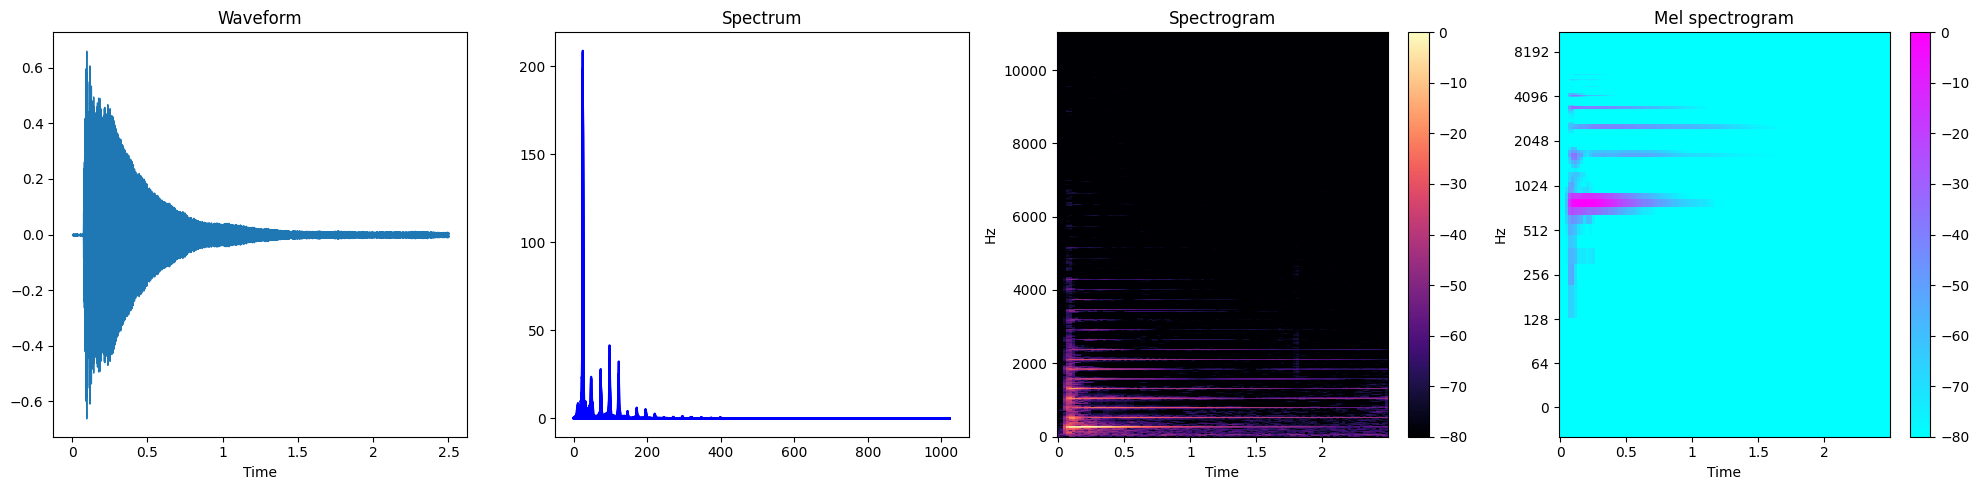

In [17]:
# Visualization
middle_c_piano, sample_rate = librosa.load('piano__c.wav')
hop_length = 512
FRAME_SIZE = 1024
n_fft = 2048

fig, axes= plt.subplots(nrows=1, ncols=4, figsize=(20, 5))
# Waveform
librosa.display.waveshow(y = middle_c_piano, sr = sample_rate, ax=axes[0])
axes[0].set_title("Waveform")

# Spectrum
stft_data = np.abs(librosa.stft(y = middle_c_piano, n_fft = n_fft,hop_length = hop_length))
axes[1].plot(stft_data, color='b')
axes[1].set_title("Spectrum")

# Spectrogram
spec = librosa.amplitude_to_db(np.abs(librosa.stft(middle_c_piano)), ref=np.max)
img=librosa.display.specshow(spec, x_axis='time', y_axis='linear', ax=axes[2])
fig.colorbar(img, ax=axes[2])
axes[2].set_title("Spectrogram")

# Mel spectrogram
mel_spec = librosa.feature.melspectrogram(y=middle_c_piano, sr=sample_rate,hop_length = hop_length)
mel_spec_db = librosa.amplitude_to_db(mel_spec, ref=np.max)
img = librosa.display.specshow(mel_spec_db, sr = sample_rate, hop_length = hop_length, x_axis = 'time', y_axis = 'log',cmap = 'cool',ax=axes[3])
fig.colorbar(img, ax=axes[3])
axes[3].set_title("Mel spectrogram")

plt.tight_layout()
plt.show()
fig.savefig("four_plots.png", dpi=fig.dpi)

## Generate sound

An example is based on [RealPyton](https://realpython.com/python-scipy-fft/).

In digital audio, 44,100 Hz (alternately represented as 44.1 kHz) is a common sampling frequency. SAMPLE_RATE determines how many data points the signal uses to represent the sine wave per second. So if the signal had a sample rate of 10 Hz and was a five-second sine wave, then it would have 10 * 5 = 50 data points.

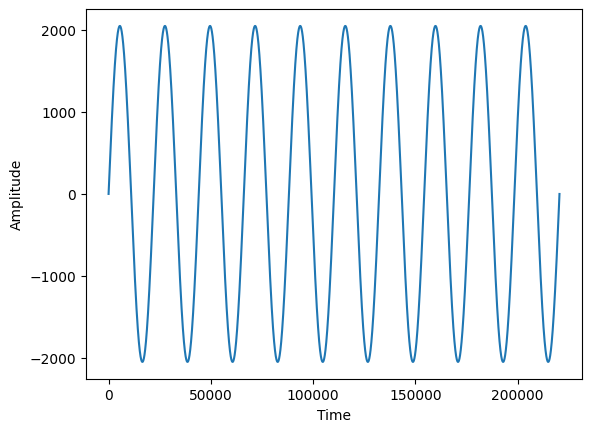

In [18]:
# Generate a sine wave
SAMPLE_RATE = 44100  # Hertz
DURATION = 5  # Seconds
AMPLITUDE = 2048 #db

def generate_sine_wave(freq, sample_rate=44100, duration=1, amplitude=2048):
    """ Generate a sinusoid. """
    x = np.linspace(0, duration, int(sample_rate * duration), endpoint=False)
    frequencies = x * freq
    # 2pi because np.sin takes radians
    y = amplitude*np.sin((2 * np.pi) * frequencies)
    return y

# Generate a 2 hertz sine wave that lasts for 5 seconds
y = generate_sine_wave(2, SAMPLE_RATE, DURATION)
plt.plot( y)
plt.xlabel("Time")
plt.ylabel("Amplitude")
plt.show()

## Generate a complex sound

Let's generate three notes for the C major chord - C, E, and G and generate the chord:

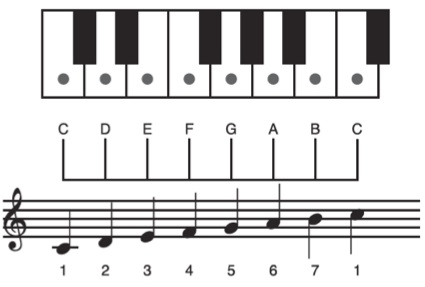

In [19]:
# Create a complex tone for C chord:
note_C = generate_sine_wave(261.626, SAMPLE_RATE, DURATION, amplitude=2048)
note_E = generate_sine_wave(329.628, SAMPLE_RATE, DURATION, amplitude=2048)
note_G = generate_sine_wave(391.995, SAMPLE_RATE, DURATION, amplitude=2048)

C_chord = note_C + note_E + note_G

Text(0, 0.5, 'Amplitude')

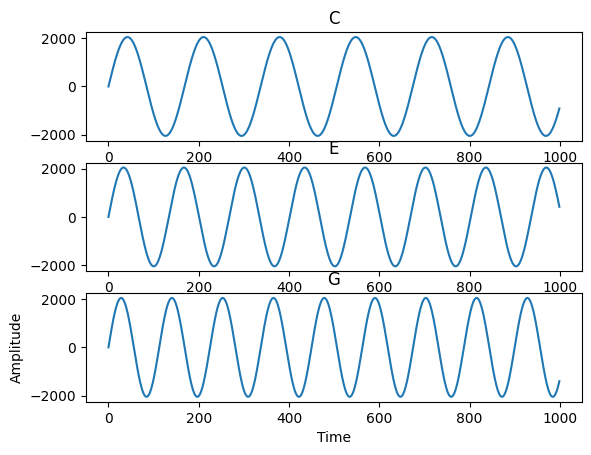

In [20]:
fig, axs = plt.subplots(3)
axs[0].plot(note_C[:1000])
axs[0].set_title("C")
axs[1].plot(note_E[:1000])
axs[1].set_title("E")
axs[2].plot(note_G[:1000])
axs[2].set_title("G")
plt.xlabel("Time")
plt.ylabel("Amplitude")


The next step is normalization, or scaling the signal to fit into the target format.     Due to how you'll store the audio later, your target format is a 16-bit integer,      which has a range from -32768 to 32767:

In [21]:
def normalize_tone(x):
    """Scale / normalize the signal to 16-bit integer,
    which has a range from -32768 to 32767. """
    return np.int16((x / x.max()) * 32767)

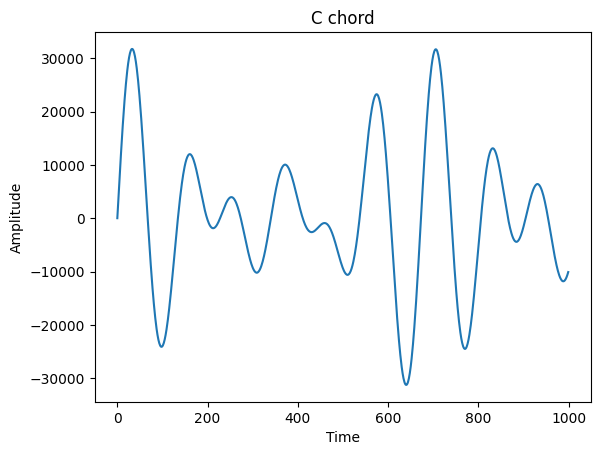

In [22]:
# Normalize it:
note_C = normalize_tone(note_C)
note_E = normalize_tone(note_E)
note_G = normalize_tone(note_G)
C_chord = normalize_tone(C_chord)

plt.plot(C_chord[:1000])
plt.xlabel("Time")
plt.ylabel("Amplitude")
plt.title('C chord')
plt.show()

In [23]:
# Remember SAMPLE_RATE = 44100 Hz is our playback rate
write("note_C.wav", SAMPLE_RATE, note_C)
write("note_E.wav", SAMPLE_RATE, note_E)
write("note_G.wav", SAMPLE_RATE, note_G)
write("C_chord.wav", SAMPLE_RATE, C_chord)

In [ ]:
IPython.display.Audio("note_C.wav")

In [ ]:
IPython.display.Audio("note_E.wav")

In [ ]:
IPython.display.Audio("note_G.wav")

In [16]:
IPython.display.Audio("C_chord.wav")

## Fourier transform

The information below is from [RealPyton](https://realpython.com/python-scipy-fft/).

**scipy.fft vs scipy.fftpack**

SciPy documentaion has two similar functions:

The **scipy.fft** module is *newer* and should be preferred over scipy.fftpack. You can read more about the change in the release notes for SciPy 1.4.0, but here’s a quick summary:

- scipy.fft has an improved API.
- scipy.fft enables using multiple workers, which can provide a speed boost in some situations.
- scipy.fftpack is considered legacy, and SciPy recommends using scipy.fft instead.

Unless you have a good reason to use scipy.fftpack, you should stick with scipy.fft.

**scipy.fft vs numpy.fft**

SciPy’s fast Fourier transform (FFT) implementation contains *more features* and is more likely to get bug fixes than NumPy’s implementation. If given a choice, you should use the SciPy implementation.

NumPy maintains an FFT implementation for backward compatibility even though the authors believe that functionality like Fourier transforms is best placed in SciPy. See the SciPy FAQ for more details.

The code calls two very important functions:

- **fft()** calculates the transform itself.

- **fftfreq()** calculates the frequencies in the center of each bin in the output of fft(). Without this, there would be no way to plot the x-axis on your frequency spectrum.

A **bin** is a range of values that have been grouped, like in a histogram. For more information on bins, see this Signal Processing Stack Exchange question. For the purposes of this tutorial, you can think of them as just single values.

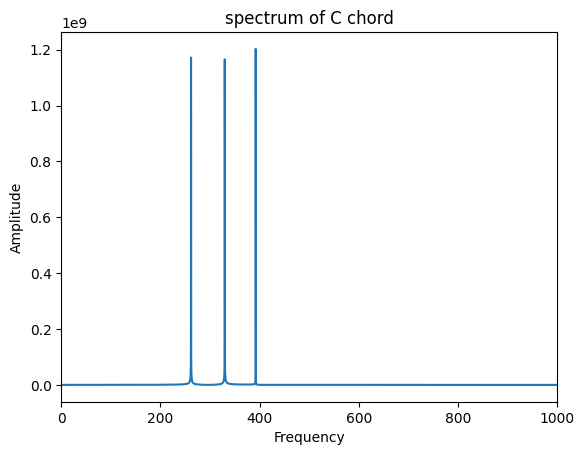

In [24]:
from scipy.fft import rfft, rfftfreq

# Number of samples in normalized_tone
N = SAMPLE_RATE * DURATION

# Note the extra 'r' at the front
yf = rfft(C_chord)
xf = rfftfreq(N, 1 / SAMPLE_RATE)

plt.plot(xf, np.abs(yf))
plt.xlim(0,1000)
plt.xlabel('Frequency')
plt.ylabel('Amplitude')
plt.title ("spectrum of C chord")
plt.show()

In [ ]:
# note_C ~ (261.626)
# note_E ~ (329.6288)
# note_G ~ (391.995)

# Math and Music

## Create notes from formula
A handy piece of code for getting frqeuencies of any note is from [this post](https://towardsdatascience.com/music-in-python-2f054deb41f4).

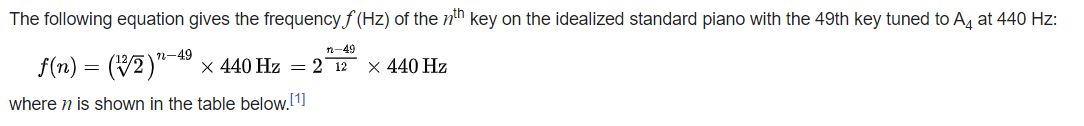

In [25]:
def get_piano_notes():
    """ Get frequency of any note using the formula."""

    # White keys are in Uppercase and black keys (sharps) are in lowercase
    octave = ['C', 'c', 'D', 'd', 'E', 'F', 'f', 'G', 'g', 'A', 'a', 'B']
    base_freq = 440 #Frequency of Note A4
    keys = np.array([x+str(y) for y in range(0,9) for x in octave])
    # Trim to standard 88 keys
    start = np.where(keys == 'A0')[0][0]
    end = np.where(keys == 'C8')[0][0]
    keys = keys[start:end+1]

    note_freqs = dict(zip(keys, [2**((n+1-49)/12)*base_freq for n in range(len(keys))]))
    note_freqs[''] = 0.0 # silence
    return note_freqs


# Get middle C frequency
note_freqs = get_piano_notes()
note_C = note_freqs['C4']
print(note_C)

261.6255653005986


In [26]:
# Create C minor
c_chord = generate_sine_wave(note_freqs['C4'], duration=5) + \
          generate_sine_wave(note_freqs['d4'], duration=5) + \
          generate_sine_wave(note_freqs['G4'], duration=5)
c_chord = normalize_tone(c_chord)
write("c_chord.wav", SAMPLE_RATE, c_chord)

In [38]:
IPython.display.Audio("C_chord.wav")

In [39]:
IPython.display.Audio("c_chord.wav")

Now we have two chords - C major and C minor. Let's see their plots:

In [27]:
def plot_sound(signalData, samplingFrequency = 44100):

    plt.subplot(211)


    plt.plot(signalData[:20000])
    plt.xlabel('Sample')
    plt.ylabel('Amplitude')
    plt.title('Waveform of a wav file with piano music')

    plt.subplot(212)
    plt.specgram(signalData,Fs=samplingFrequency)
    plt.xlabel('Time')
    plt.ylabel('Frequency')
    plt.title('Spectrum of a wav file with piano music')

    plt.tight_layout()
    plt.show()

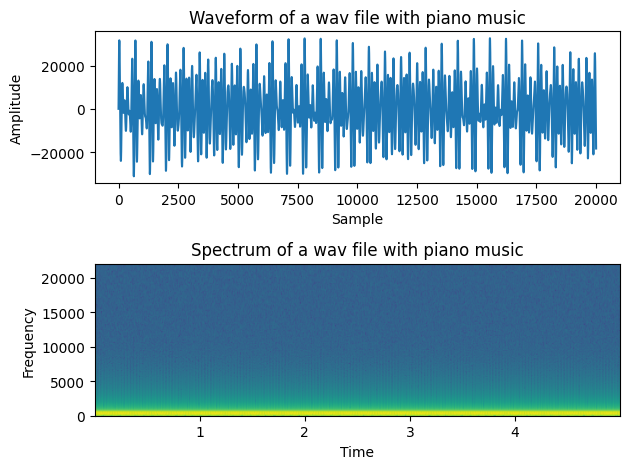

In [28]:
plot_sound(C_chord)

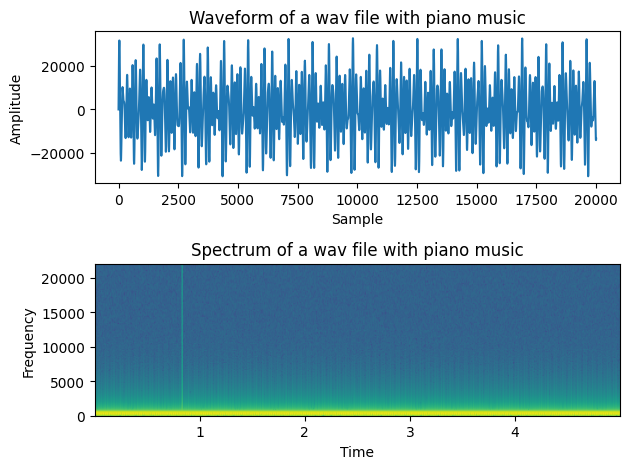

In [29]:
plot_sound(c_chord)

## Transform to piano

 If compared to the piano sound of C chord, the generated one sounds very differently because it lacks the piano timbre composed by overtones.

In [ ]:
IPython.display.Audio("note_C.wav")

In [ ]:
IPython.display.Audio("piano__c.wav")

In [30]:
# Load data from wav file
sample_rate, middle_c_piano = read('piano__c.wav')
sample_rate, middle_c_synth = read('note_C.wav')
print(sample_rate)
print(middle_c_synth[:50])

44100
[    0  1221  2440  3656  4867  6071  7267  8453  9627 10787 11933 13062
 14172 15264 16334 17381 18404 19401 20372 21314 22227 23109 23958 24775
 25557 26303 27013 27685 28319 28914 29468 29982 30453 30883 31270 31613
 31912 32167 32377 32542 32662 32737 32766 32750 32688 32581 32428 32230
 31988 31701]


<ipython-input-47-02f127d59d22>:1: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-dark')


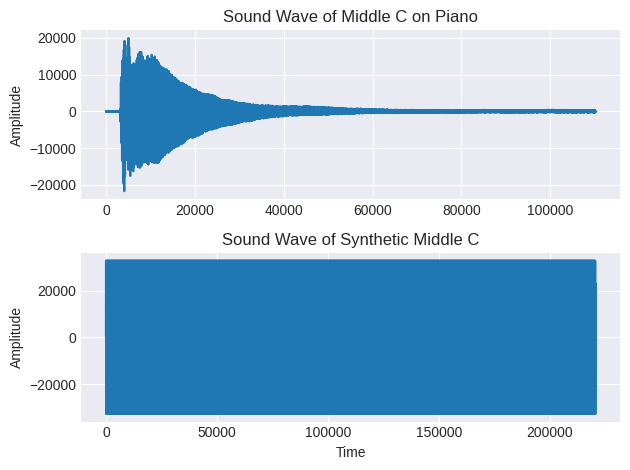

In [47]:
plt.style.use('seaborn-dark')

# Plot sound wave
plt.subplot(211)
plt.plot(middle_c_piano)
# plt.xlabel('Time')
plt.ylabel('Amplitude')
plt.title('Sound Wave of Middle C on Piano')
plt.grid()

plt.subplot(212)
plt.plot(middle_c_synth)
plt.xlabel('Time')
plt.ylabel('Amplitude')
plt.title('Sound Wave of Synthetic Middle C')
plt.grid()
plt.tight_layout()
plt.savefig("waveforms_of_C4.png")

The wave is not “smooth” because of the existence of **overtones**. The sound wave above is actually a combination of waves with frequencies that are **multiples** (including 1, for the note itself) **of the middle C**.

The middle C in this case is our fundamental note. Overtones are multiples of the fundamental.

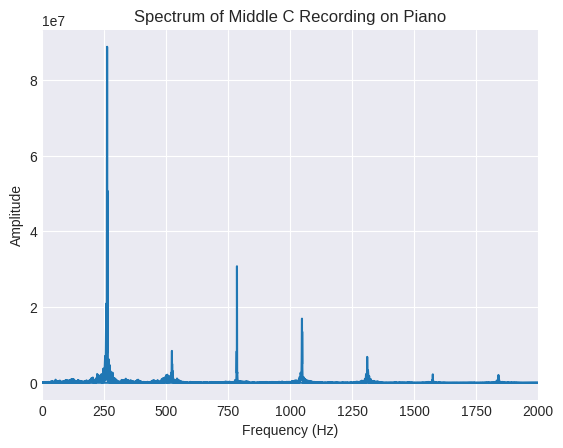

In [45]:
#FFT
t = np.arange(middle_c_piano.shape[0])
freq = np.fft.fftfreq(t.shape[-1])*sample_rate
sp = np.fft.fft(middle_c_piano)

# Plot spectrum
plt.plot(freq, abs(sp.real))
plt.xlabel('Frequency (Hz)')
plt.ylabel('Amplitude')
plt.title('Spectrum of Middle C Recording on Piano')
plt.xlim((0, 2000))
plt.grid()
plt.savefig("spectrum_piano_C.png")

C4 Middle C	~ 261.6256

C5 Tenor C	~ 523.2511

C6 Soprano C (High C) ~ 1046.502

C7 Double high C ~ 2093.005

C8 Eighth octave ~	4186.009

A code sample is based on [this post](https://towardsdatascience.com/music-in-python-2f054deb41f4):

In [37]:
def extract_overtones(instrument_sound, frequency, sample_rate=44100):
    """The piece of code below calculates the ratio of the magnitude
    between each overtone and the fundamental from the piano sample
    so that we can apply that to our pure sine waves."""

    t = np.arange(instrument_sound.shape[0])
    freq = np.fft.fftfreq(t.shape[-1])*sample_rate
    sp = np.fft.fft(instrument_sound)

    # Get positive frequency
    idx = np.where(freq > 0)[0]
    freq = freq[idx]
    sp = sp[idx]

    # Get dominant frequencies
    sort = np.argsort(-abs(sp.real))[:100]
    dom_freq = freq[sort]

    # Round and calculate amplitude ratio
    freq_ratio = np.round(dom_freq/frequency)
    unique_freq_ratio = np.unique(freq_ratio)
    amp_ratio = abs(sp.real[sort]/np.sum(sp.real[sort]))
    factor = np.zeros((int(unique_freq_ratio[-1]), ))
    for i in range(factor.shape[0]):
        idx = np.where(freq_ratio==i+1)[0]
        factor[i] = np.sum(amp_ratio[idx])
    factor = factor/np.sum(factor)

    return factor

piano_factor = extract_overtones(middle_c_piano, note_freqs['C4'])
print(piano_factor)

[0.77814929 0.03482352 0.06150581 0.08752367 0.03438142 0.
 0.         0.00361628]


In [38]:
def apply_overtones(frequency, duration, factor, sample_rate=44100, amplitude=4096):

    assert abs(1-sum(factor)) < 1e-8

    frequencies = np.minimum(np.array([frequency*(x+1) for x in range(len(factor))]), sample_rate//2)
    amplitudes = np.array([amplitude*x for x in factor])

    fundamental = generate_sine_wave(frequencies[0], sample_rate, duration, amplitudes[0])
    for i in range(1, len(factor)):
        overtone = generate_sine_wave(frequencies[i], sample_rate, duration, amplitudes[i])
        fundamental += overtone
    return fundamental

# Construct harmonic series
note = apply_overtones(note_freqs['C4'], duration=2, factor=piano_factor)
write("note_c_with_overtones.wav", SAMPLE_RATE, normalize_tone(note))

In [35]:
IPython.display.Audio("note_C.wav")

In [49]:
IPython.display.Audio("note_c_with_overtones.wav")

In [ ]:
IPython.display.Audio("piano__c.wav")

In [39]:
def get_adsr_weights(frequency, duration, length, decay, sustain_level, sample_rate=44100):
    """When we press an actual piano key, it started out light before quickly
    getting louder, and the sound diminishes over time.
    One model to describe how the sound changes is ADSR (attack, decay, sustain and release).
     Essentially it describes sound as going through four stages:
     the initial stage of incline, then descending to a lower level,
     maintaining there for a little while before diminishing to zero."""


    assert abs(sum(length)-1) < 1e-8
    assert len(length) ==len(decay) == 4

    intervals = int(duration*frequency)
    len_A = np.maximum(int(intervals*length[0]),1)
    len_D = np.maximum(int(intervals*length[1]),1)
    len_S = np.maximum(int(intervals*length[2]),1)
    len_R = np.maximum(int(intervals*length[3]),1)

    decay_A = decay[0]
    decay_D = decay[1]
    decay_S = decay[2]
    decay_R = decay[3]

    A = 1/np.array([(1-decay_A)**n for n in range(len_A)])
    A = A/np.nanmax(A)
    D = np.array([(1-decay_D)**n for n in range(len_D)])
    D = D*(1-sustain_level)+sustain_level
    S = np.array([(1-decay_S)**n for n in range(len_S)])
    S = S*sustain_level
    R = np.array([(1-decay_R)**n for n in range(len_R)])
    R = R*S[-1]

    weights = np.concatenate((A,D,S,R))
    smoothing = np.array([0.1*(1-0.1)**n for n in range(5)])
    smoothing = smoothing/np.nansum(smoothing)
    weights = np.convolve(weights, smoothing, mode='same')

    weights = np.repeat(weights, int(sample_rate*duration/intervals))
    tail = int(sample_rate*duration-weights.shape[0])
    if tail > 0:
        weights = np.concatenate((weights, weights[-1]-weights[-1]/tail*np.arange(tail)))
    return weights

In [41]:
# Getting it all together:

def get_a_piano_note(note, factor, duration=1, amplitude=4096):

    frequency = note_freqs[note]
    note = apply_overtones(frequency, duration=duration, factor=factor)

    weights = get_adsr_weights(frequency,
                               duration=duration,
                               length=[0.05, 0.25, 0.55, 0.15],
                               decay=[0.075,0.02,0.005,0.1],
                               sustain_level=0.1)
    data = note*weights

    return data

# Read synthesized sounds:
sample_rate, middle_c_piano = read('piano__c.wav')

# Extract Overones
piano_factor = extract_overtones(middle_c_piano, note_freqs['C4'])

# Write to file
note_c_with_overtones_ADSR = normalize_tone(get_a_piano_note('C4', factor=piano_factor, duration=3))
write("note_c_with_overtones_ADSR.wav", 44100, note_c_with_overtones_ADSR)

In [ ]:
IPython.display.Audio("note_c.wav")

In [ ]:
IPython.display.Audio("note_c_1.wav")

In [59]:
IPython.display.Audio("note_c_with_overtones_ADSR.wav")

In [ ]:
IPython.display.Audio("piano__c.wav")

## Write a melody

In [42]:
len(get_a_piano_note('C4', piano_factor, duration=1))

44100

In [43]:
def dogs_waltz(factor, amplitude=2048, temp = 1/3):
    """Generating a Dog's Waltz song.
    The melody is: f-gg, f-gg, e-aa, e-aa, d-hh, d-hh, cc, cc, cc, cc"""

    F4 = get_a_piano_note('F4', factor, duration=temp*3)
    G4 = get_a_piano_note('G4', factor, duration=temp)

    E4 = get_a_piano_note('E4', factor, duration=temp*3)
    E4_short = get_a_piano_note('E4', factor, duration=temp)
    A4 = get_a_piano_note('A4', factor, duration=temp)

    D4 = get_a_piano_note('D4', factor, duration=temp*3)
    D4_short = get_a_piano_note('D4', factor, duration=temp)
    H4 = get_a_piano_note('B4', factor, duration=temp)

    C4 = get_a_piano_note('C4', factor, duration=temp)
    C5 = get_a_piano_note('C5', factor, duration=temp)

    C4_long = get_a_piano_note('C4', factor, duration=temp*3)
    C5_long = get_a_piano_note('C5', factor, duration=temp*3)

    pause = np.zeros(len(G4))

    # Refren:
    piece1_hand1 = np.concatenate((F4, F4, E4, E4, D4, D4, C4, C4, C4), axis=None)
    piece_1_hand2 = np.concatenate((pause, G4, G4, pause, G4, G4, pause, G4, G4,  pause, G4, G4, pause, H4, H4, pause, H4, H4, C5, C5, C5), axis=None)

    assert len(piece1_hand1) == len(piece_1_hand2)

    # Full piece
    full_piece_hand1 = np.concatenate((piece1_hand1, C5, D4_short,  E4_short, piece1_hand1, C4_long), axis=None)
    full_piece_hand2 = np.concatenate((piece_1_hand2, C4, H4, A4, piece_1_hand2, C5_long), axis=None)

    assert len(full_piece_hand1) == len(full_piece_hand2)

    music = full_piece_hand1 + full_piece_hand2

    write("waltz.wav", SAMPLE_RATE, normalize_tone(music))

In [44]:
dogs_waltz(piano_factor, amplitude=2048, temp = 1/3)

In [69]:
IPython.display.Audio("waltz.wav")